# Bibliotecas

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql import Row
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)

Sessão Spark (Não necessário para rodar no Databricks)

In [2]:
spark = (
    SparkSession.builder
    .appName("ForecastApp")
    .config("spark.driver.memory", "2g") # Aumente este valor (ex: de 1g para 2g ou 4g)
    .getOrCreate()
)

In [3]:
#  Datasets Kaggle (Rodar só uma vez)

# api = KaggleApi()
# api.authenticate()

# api.competition_download_files('demand-forecasting-kernels-only', path='datasets')

# Entrada de Dados

In [4]:
df = spark.read.csv('datasets/train.csv', header=True)

df.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows


# Fundamentos de Média Móvel

## Média Móvel Simples

In [5]:
window3 = Window.orderBy('date').rowsBetween(-2,0)
window7 = Window.orderBy('date').rowsBetween(-6,0)
window30 = Window.orderBy('date').rowsBetween(-29,0)
window119 = Window.orderBy('date').rowsBetween(-119,0)
window360 = Window.orderBy('date').rowsBetween(-359,0)


df_with_sma = (
    df
    .filter((F.col('item') == 1) & (F.col('store')== 1))
    .withColumn('SMA_3', F.avg(F.col('sales')).over(window3))
    .withColumn('SMA_7', F.avg(F.col('sales')).over(window7))
    .withColumn('SMA_30', F.avg(F.col('sales')).over(window30))
    .withColumn('SMA_120', F.avg(F.col('sales')).over(window119))
    .withColumn('SMA_360', F.avg(F.col('sales')).over(window360))
)

df_with_sma.show()

+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|      date|store|item|sales|             SMA_3|             SMA_7|            SMA_30|           SMA_120|           SMA_360|
+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|2013-01-01|    1|   1|   13|              13.0|              13.0|              13.0|              13.0|              13.0|
|2013-01-02|    1|   1|   11|              12.0|              12.0|              12.0|              12.0|              12.0|
|2013-01-03|    1|   1|   14|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|
|2013-01-04|    1|   1|   13|12.666666666666666|             12.75|             12.75|             12.75|             12.75|
|2013-01-05|    1|   1|   10|12.333333333333334|              12.2|              12.2|              12.2|              12.2|


## Plot - SMA

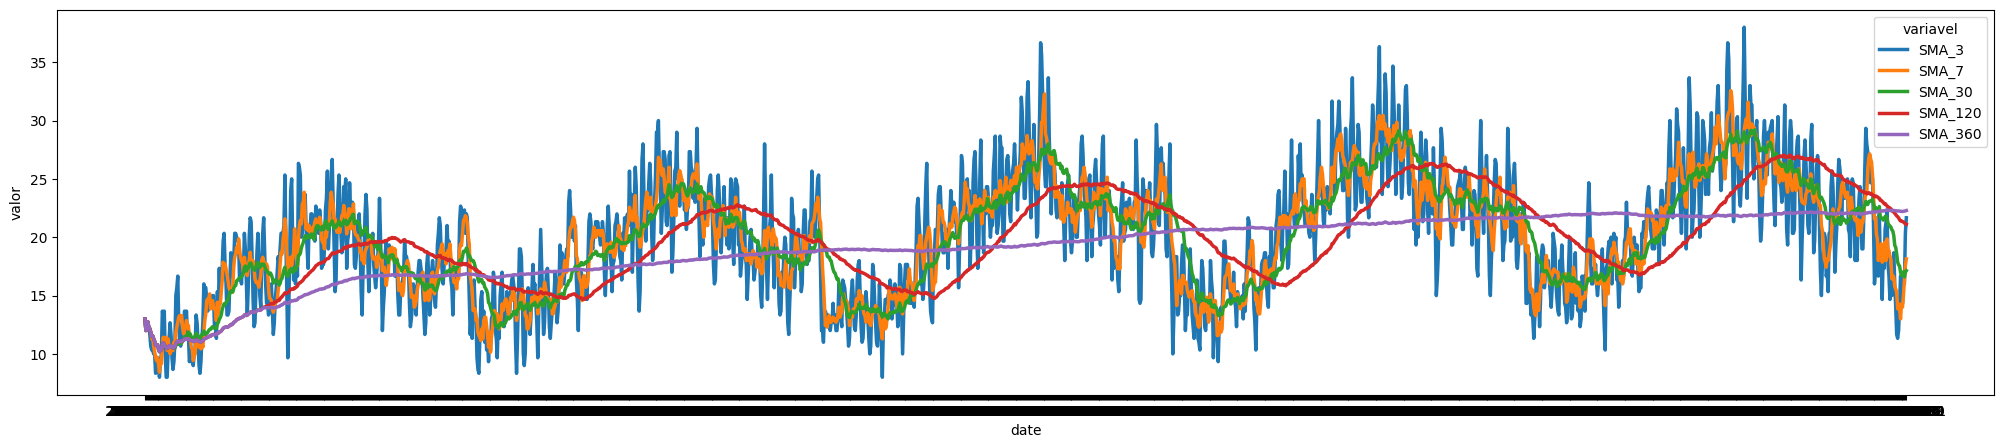

In [6]:
df_plot = df_with_sma.toPandas()

plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['SMA_3', 'SMA_7', 'SMA_30', 'SMA_120', 'SMA_360'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

## Média Móvel Exponencial

In [7]:
df_plot['sales'] = pd.to_numeric(df_plot['sales'])

df_plot['EMA_120'] = df_plot['sales'].ewm(span=120, adjust=False).mean()

df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375


## Plot - EMA

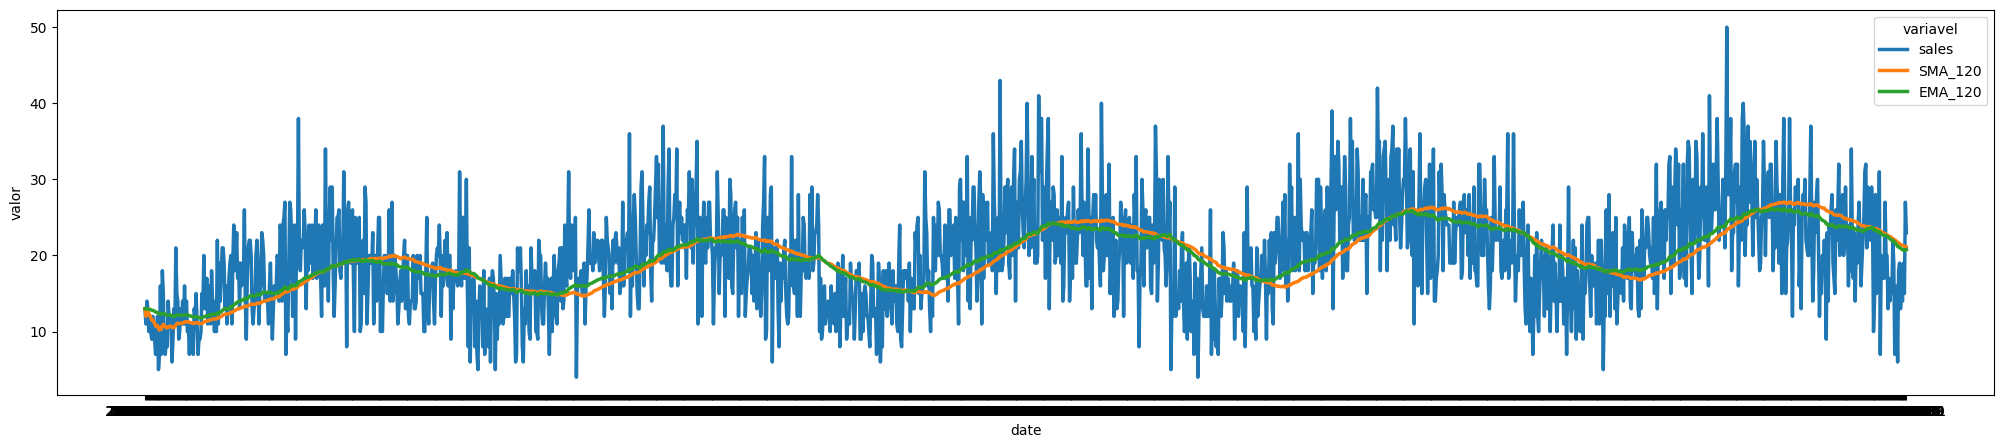

In [8]:
plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['sales','SMA_120', 'EMA_120'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

## Média Móvel Ponderada (WMA)

A WMA vai ser calculada usando peso definido de acordo com a data (quanto mais próximo, mais forte o valor da média) - Peso Linear

In [9]:
df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375


In [10]:
size = 120

weight = np.arange(1, size+1)

df_plot[f'WMA_{size}'] = df_plot['sales'].rolling(size).apply(lambda x: np.dot(x, weight)/weight.sum(), raw=True)

df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120,WMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,NaN
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942,NaN
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017,NaN
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282,NaN
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390,20.031405
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507,19.992700
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987,19.888292
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375,19.983747


## Plot WMA

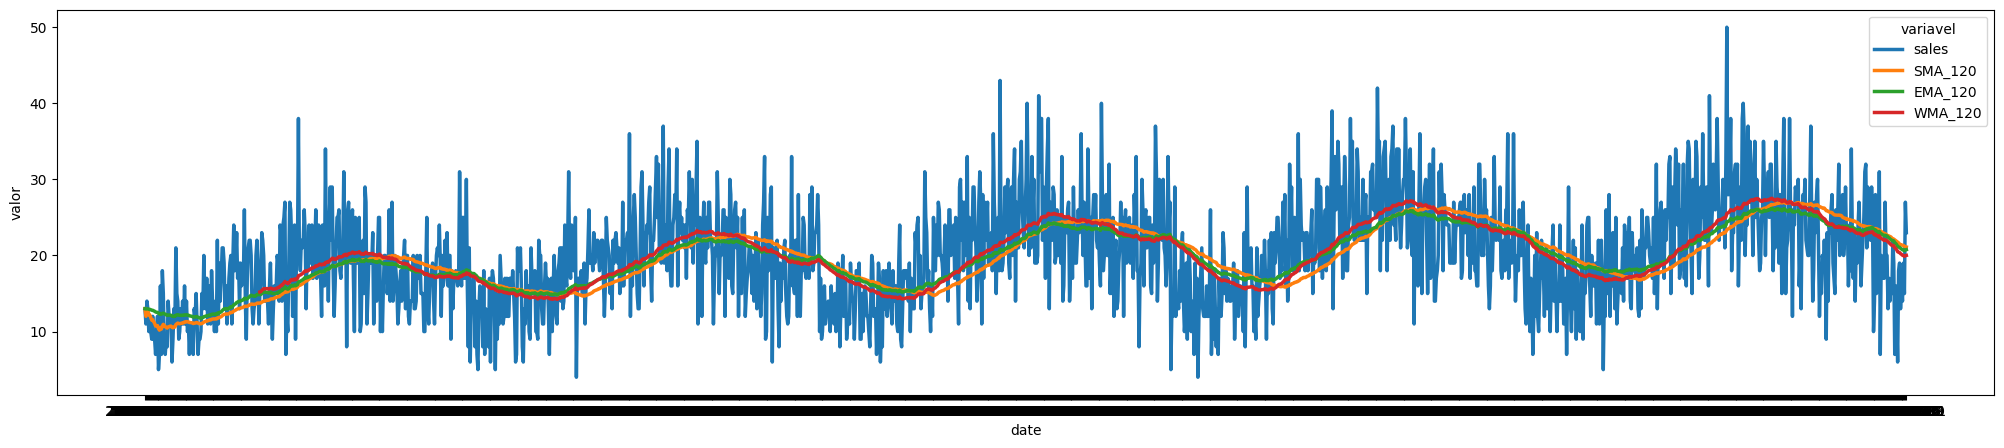

In [11]:
plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['sales','SMA_120', 'EMA_120', 'WMA_120'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

# Projeções com Baseline

## Baseline Constante

In [13]:


min_date = pd.to_datetime(df_plot['date'].max())

days_to_add = 15

df_datas = (
    spark.range(1)
    .selectExpr(f"to_date('{min_date}') as min_date")
    .withColumn("max_date", F.date_add(F.col("min_date"), days_to_add))
    .withColumn(
        "datas",
        F.expr("sequence(min_date, max_date, interval 1 day)")
    )
)

df_datas = df_datas.select(F.explode("datas").alias("data"))

# df_datas.show()



In [17]:
df_baseline = (
    df_with_sma
    .drop('SMA_3', 'SMA_30', 'SMA_120', 'SMA_360')
    .sort(F.desc(F.col('date')))
)

window7 = Window.orderBy('date').rowsBetween(-6,0)

# A data tem que ser um ponto fixo antes da iteração
max_date = df_baseline.select(F.max('date')).collect()[0][0]
max_date = datetime.strptime(str(max_date), "%Y-%m-%d").date()

days_to_add = 15

for i in range(days_to_add):

    df_baseline = df_baseline.cache()

    new_date = max_date + timedelta(days=i+1)

    max_sma7 = df_baseline.select(F.round(F.col('SMA_7'), 2)).limit(1).collect()[0][0]   

    newrow = spark.createDataFrame([{
        'date':     new_date,
        'store':    1,
        'item':     1,
        'sales':    float(max_sma7)
    }])

    df_baseline = (
        df_baseline
        .drop('SMA_7')
        .unionByName(newrow)
        .withColumn('SMA_7', F.round(F.avg(F.col('sales')).over(window7), 2))
        .sort(F.desc(F.col('date')))
    )


df_baseline.sort(F.desc('date')).show()


+----------+-----+----+-----+-----+
|      date|store|item|sales|SMA_7|
+----------+-----+----+-----+-----+
|2018-01-15|    1|   1|19.98|20.02|
|2018-01-14|    1|   1|19.99|19.98|
|2018-01-13|    1|   1|20.11|19.99|
|2018-01-12|    1|   1|20.12|20.11|
|2018-01-11|    1|   1|20.11|20.12|
|2018-01-10|    1|   1| 20.0|20.11|
|2018-01-09|    1|   1|19.86| 20.0|
|2018-01-08|    1|   1|19.65|19.86|
|2018-01-07|    1|   1|20.07|19.65|
|2018-01-06|    1|   1|20.93|20.07|
|2018-01-05|    1|   1|20.19|20.93|
|2018-01-04|    1|   1|20.04|20.19|
|2018-01-03|    1|   1|19.29|20.04|
|2018-01-02|    1|   1|18.88|19.29|
|2018-01-01|    1|   1|18.14|18.88|
|2017-12-31|    1|   1| 23.0|18.14|
|2017-12-30|    1|   1| 27.0|17.57|
|2017-12-29|    1|   1| 15.0|16.29|
|2017-12-28|    1|   1| 19.0| 15.0|
|2017-12-27|    1|   1| 14.0| 14.0|
+----------+-----+----+-----+-----+
only showing top 20 rows
